# SHAP Interpretability: Understanding XGBoost Predictions

This notebook demonstrates how to use SHAP (SHapley Additive exPlanations) to interpret the predictions of an XGBoost model trained to predict final score margin.

SHAP is a method that explains the output of machine learning models by assigning each feature an importance value for a particular prediction. It uses concepts from cooperative game theory to fairly distribute the "payout" (the model's prediction) among the features (the inputs). Each feature's SHAP value indicates how much that feature contributed to the difference between the model's prediction and the average prediction across all data points. This helps us understand which features are driving the model's predictions and how they interact with each other.

## 1. Load and Prepare Data

As with previous notebooks, we will load the data into a DataFrame, select some continuous and categorical features, and create dummy variables for the categorical features.

In [ ]:
import pandas as pd

df = pd.read_csv("training_data.csv")

cont_features = [
    'home_elo', 'away_elo',
    'home_adjusted_epa', 'away_adjusted_epa',
    'home_adjusted_epa_allowed', 'away_adjusted_epa_allowed',
    'home_adjusted_success', 'away_adjusted_success',
    'home_adjusted_success_allowed', 'away_adjusted_success_allowed'
]
cat_features = ['week', 'home_conference', 'away_conference']
df = pd.get_dummies(df, columns=cat_features, drop_first=True)

dummy_columns = []
for cat in cat_features:
    dummy_columns += [c for c in df.columns if cat in c]

features = dummy_columns + cont_features

df[features]

,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12,week_13,week_14,...,away_adjusted_line_yards,away_adjusted_rushing_epa,home_adjusted_open_field_yards_allowed,home_db_havoc_defense,away_adjusted_open_field_yards_allowed,away_adjusted_line_yards_allowed,home_avg_start_defense,away_total_havoc_defense,home_front_seven_havoc_defense,home_talent
0,True,False,False,False,False,False,False,False,False,False,...,2.927454,0.115922,1.614072,0.029289,1.174939,2.838073,71.5,0.114865,0.092050,520.26
1,True,False,False,False,False,False,False,False,False,False,...,2.957792,0.086819,1.453171,0.096886,1.094620,2.732965,62.9,0.211454,0.103806,619.03
2,True,False,False,False,False,False,False,False,False,False,...,3.034529,0.093526,1.390987,0.085427,1.098129,2.815409,70.7,0.173759,0.065327,872.00
3,True,False,False,False,False,False,False,False,False,False,...,3.059674,0.148207,1.369826,0.083665,1.084415,3.246245,74.1,0.149068,0.127490,982.66
4,True,False,False,False,False,False,False,False,False,False,...,3.120834,0.157972,1.272610,0.072626,1.299486,2.664002,70.1,0.227586,0.044693,654.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4515,False,False,False,False,False,False,False,False,False,False,...,2.732079,0.110430,0.979838,0.064738,1.428344,3.223264,71.9,0.137097,0.121212,488.03
4516,False,False,False,False,False,False,False,False,False,False,...,3.124902,0.165929,1.155971,0.051348,1.217332,3.354678,74.0,0.132484,0.086008,766.50
4517,False,False,False,False,False,False,False,False,False,False,...,2.854012,0.109811,1.416645,0.072483,1.377233,3.240742,67.5,0.141634,0.151678,644.36
4518,False,False,False,False,False,False,False,False,False,False,...,2.904797,0.118350,1.039955,0.067949,1.136516,2.610712,71.8,0.192547,0.123077,571.92


## 2. Train/Test Split and Model

We will use `train_test_split` as before to create training and testing datasets. We will create another XGBoost model, but this time we will use `XGBRegressor` since we are predicting a continuous variable (final score margin) rather than a classification problem.

In [59]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

X = df[features]
y = df['margin']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

model = XGBRegressor(eval_metric="logloss", random_state=77)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='logloss',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, random_state=77, ...)

## 3. Explain Model with SHAP

Before using SHAP, we need to convert non-numeric features to numeric. Notably, all of our categorical features are converted to dummy boolean variables and will need to be made numeric.

We will use `shap.Explainer`, which is a tool from the SHAP library that helps us understand how a machine learning model makes its predictions. When you create an `explainer` using `shap.Explainer(model, X_train_fixed)`, you are telling SHAP to analyze your trained model and your training data. The explainer learns how the model uses each feature to make predictions.

Once you have an explainer, you can use it to calculate SHAP values for new data (like `X_test_fixed`). These SHAP values show how much each feature contributed to the model's prediction for each example. This makes it easier to see which features are most important and how they affect the outcome, helping you interpret and trust your model's decisions.

In [20]:
import shap

# Ensure all columns are numeric (convert bool to int, others to float)
X_train_fixed = X_train.copy()
X_test_fixed = X_test.copy()
for col in X_train_fixed.columns:
	if X_train_fixed[col].dtype == 'bool':
		X_train_fixed[col] = X_train_fixed[col].astype(int)
		X_test_fixed[col] = X_test_fixed[col].astype(int)
	else:
		X_train_fixed[col] = X_train_fixed[col].astype(float)
		X_test_fixed[col] = X_test_fixed[col].astype(float)

explainer = shap.Explainer(model, X_train_fixed)
shap_values = explainer(X_test_fixed)

## 4. Visualize Feature Importance

`shap.plots.beeswarm` is a visualization tool in the SHAP library that helps us understand the impact of each feature on the model's predictions. The plot displays the SHAP values for all features across all samples in the dataset.

In a beeswarm plot:
- Each point represents a SHAP value for a feature and a specific instance (or sample).
- The x-axis shows the SHAP value, which indicates how much a feature contributes to the prediction (positive values push the prediction higher, while negative values push it lower).
- The y-axis lists the features, with the most important features (those with the largest absolute SHAP values) at the top.
- Points are colored based on the feature value (e.g., red for high values and blue for low values), allowing us to see how the feature's value affects its SHAP contribution.

To interpret the plot:
- Look for features with many points far from zero; these are the most influential features.
- Check the color of the points to understand whether high or low feature values are associated with higher predictions.
- Use the plot to identify patterns, such as whether certain features consistently push predictions in one direction.

In short, the beeswarm plot provides a comprehensive view of feature importance and interactions, making it easier to interpret complex model behavior.

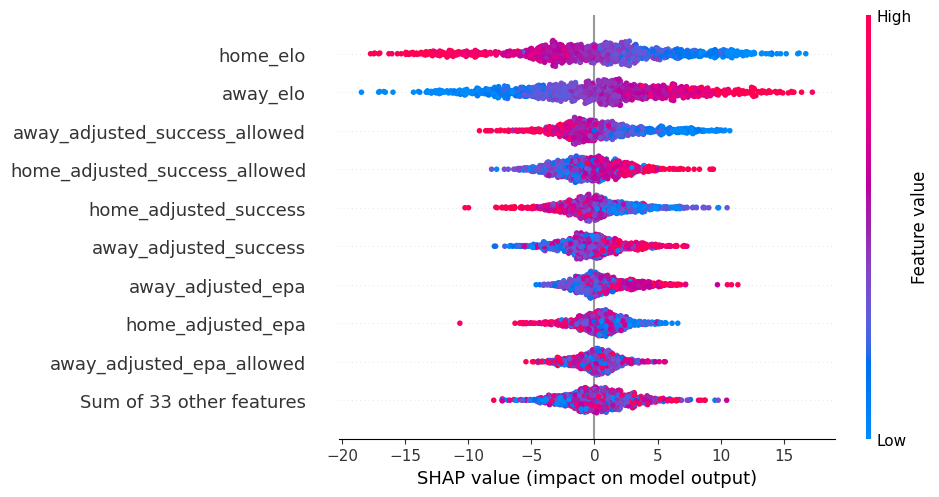

In [22]:
shap.plots.beeswarm(shap_values)

We can also visualize the feature importance using `shap.plots.bar`, which creates a bar chart showing the average absolute SHAP values for each feature. This helps us quickly identify which features have the most significant impact on the model's predictions.

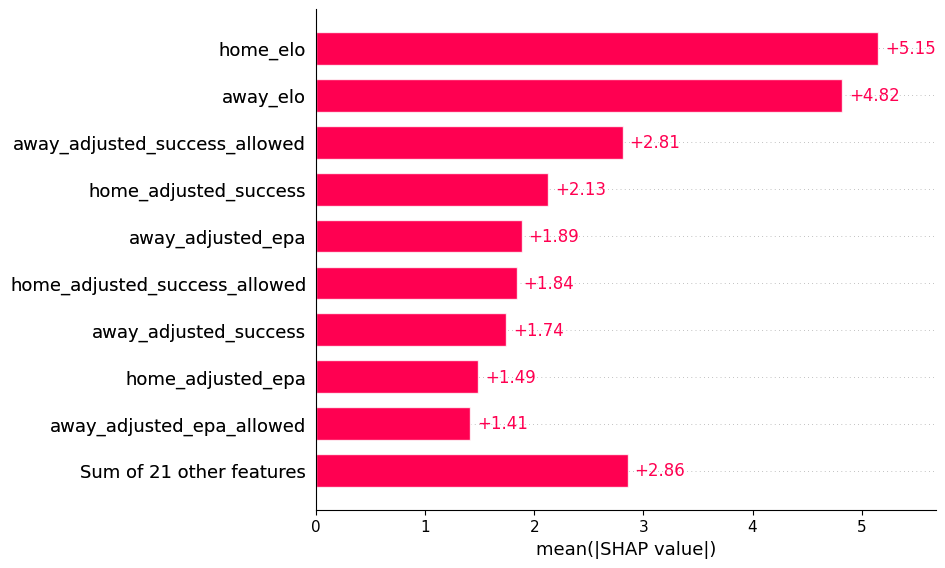

In [6]:
shap.plots.bar(shap_values)

## 5. Visualize Individual Prediction (Force Plot)

`shap.initjs` is a function from the SHAP library that initializes JavaScript visualizations in Jupyter notebooks. It enables the interactive visualizations provided by SHAP, allowing users to explore and understand the model's predictions more effectively.

`shap.force_plot` is another visualization tool in the SHAP library that creates a force plot. This plot shows the contribution of each feature to a specific prediction, helping to explain why the model made a particular decision.

To interpret the force plot:
- The plot displays the SHAP values for each feature, with the features listed on the y-axis.
- The x-axis represents the SHAP value, indicating the direction and magnitude of each feature's contribution to the prediction.
- Features pushing the prediction higher are shown on the right (positive SHAP values), while those pushing it lower are on the left (negative SHAP values).
- The length of the bars indicates the strength of each feature's impact on the prediction.

We can select a single football game from the dataset to visualize its prediction. The force plot will show how each feature contributes to the model's prediction for that specific game.

In [23]:
# Choose one game to explain
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0].values, X_test.iloc[0])

## 7. Next Steps

- Apply SHAP to other model types, such as Random Forest or Neural Networks, to compare feature importance across models.
- Apply SHAP to one of your own projects to gain insights into model predictions and feature contributions.
- Use SHAP for feature selection by identifying features with low SHAP values that can be removed without significantly affecting model performance and new features that can be added to improve model predictions.
- Explore other SHAP visualizations, such as decision plots or dependence plots, to gain deeper insights into feature interactions and model behavior.